# <center>DATA 512 Homework 1: Data Curation</center>
<center>Fall 2021</center>
<center>Author: Dwight Sablan</center>

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2021. All analysis should be performed in a single Jupyter notebook. For this assignment, I combine data about Wikipedia page traffic from two different Wikimedia REST API endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze that data.

## Step 1: Data Acqusition

IMPORT DEPENDECIES

In [16]:
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt

Set a unique User-Agent or Api-User-Agent header that allows Wikimedia to contact you quickly. Email addresses or URLs of contact pages work well.

In [26]:
headers = {
    'User-Agent': 'https://github.com/dwightsablan16',
    'From': 'sabland@uw.edu'
}

Here we set two endpoints for retrieving our data, one to get Pageviews data and the other for Pagecounts data.

In [43]:
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

Note: We're interested in organic (user) traffic, as opposed to traffic by web crawlers or spiders. for Pageviews include 'agent' parameter to do this. 

PARAMETERS FOR DESKTOP PAGEVIEWS 

In [30]:
#desktop pageviews
d_params_pageviews = {'project' : 'en.wikipedia.org',
            'access' : 'desktop',
            'agent' : 'user',
            'granularity' : 'monthly',
            'start' : '2015070100',
            #use the first day of the following month to ensure a full month of data is collected
            'end' : '2021090100'
            }

PARAMETERS FOR MOBILE-WEB PAGEVIEWS 

In [36]:
#mobile-web pageviews
mw_params_pageviews = {'project' : 'en.wikipedia.org',
            'access' : 'mobile-web',
            'agent' : 'user',
            'granularity' : 'monthly',
            'start' : '2015070100',
            #use the first day of the following month to ensure a full month of data is collected
            'end' : '2021090100'
            }

PARAMETERS FOR MOBILE-APP PAGEVIEWS 

In [37]:
#mobile-app pageviews
ma_params_pageviews = {'project' : 'en.wikipedia.org',
            'access' : 'mobile-app',
            'agent' : 'user',
            'granularity' : 'monthly',
            'start' : '2015070100',
            #use the first day of the following month to ensure a full month of data is collected
            'end' : '2021090100'
            }

PARAMETERS FOR DESKTOP PAGECOUNTS

In [45]:
#desktop pagecounts
d_params_pagecounts = {'project' : 'en.wikipedia',
            'access-site' : 'desktop-site',
            'granularity' : 'monthly',
            'start' : '2007120100',
              #use the first day of the following month to ensure a full month of data is collected
            'end' : '2016080100'
            }

PARAMETERS FOR MOBILE PAGECOUNTS

In [46]:
#mobile pagecounts
m_params_pagecounts = {'project' : 'en.wikipedia',
            'access-site' : 'mobile-site',
            'granularity' : 'monthly',
            'start' : '2007120100',
              #use the first day of the following month to ensure a full month of data is collected
            'end' : '2016080100'
            }

Here we define a function that takes in three arguments: <br> 
- endpoint 
- dictionary of parameters for data we want
- the file name we want to save it as.

In [47]:
def api_call(endpoint, parameters, filename):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    #Save json
    with open(filename,'w') as f:
        json.dump(response,f)
    
    return response

Here we call our function with the necessary parameters to load our data into our 5 source files. 

In [57]:
#Pageviews
d_pageviews = api_call(endpoint_pageviews, d_params_pageviews,'pageviews_desktop_201507-202109.json')
mw_pageviews = api_call(endpoint_pageviews, mw_params_pageviews,'pageviews_mobile-web_201507-202109.json')
ma_pageviews = api_call(endpoint_pageviews, ma_params_pageviews, 'pageviews_mobile-app_201507-202109.json')

In [58]:
#Pagecounts
d_pagecounts = api_call(endpoint_pagecounts, d_params_pagecounts,'pagecounts_desktop-site_200712-201607.json')
m_pagecounts = api_call(endpoint_pagecounts, m_params_pagecounts,'pagecounts_mobile-site_200712-201607.json')

## Step 2: Data Processing

The next step is to process the data.  For this assignment, not much data pre-processing is necessary. The steps are as follows:

- Load data from JSON files to pandas dataframes
- Combine mobile-web and mobile-app pageviews
- Create new dataframes for total pageviews and pagecounts
- Drop columns not needed in analysis
- Merge all dataframes into a single dataframe
- Export final dataframe to .csv

LOAD DATA FROM JSON FILES TO DATAFRAME OBJECTS

In [66]:
#Load pageviews data in dataframe object
d_pageviews_df = pd.DataFrame(d_pageviews['items'])
mw_pageviews_df = pd.DataFrame(mw_pageviews['items'])
ma_pageviews_df = pd.DataFrame(ma_pageviews['items'])

#Load pagecounts data in dataframe object
d_pagecounts_df = pd.DataFrame(d_pagecounts['items'])
m_pagecounts_df = pd.DataFrame(m_pagecounts['items'])

For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month

MOBILE PAGEVIEWS

In [95]:
#Combine monthly values for mobile-web and mobile-app pageviews 
m_pageviews_df = pd.concat((mw_pageviews_df,ma_pageviews_df)).groupby('timestamp',as_index=False).sum()

m_pageviews_df.columns = ["date","pageview_mobile_views"]

m_pageviews_df.head()

,date,pageview_mobile_views
0,2015070100,3288755294
1,2015080100,3302333038
2,2015090100,3170203333
3,2015100100,3268499132
4,2015110100,3236601070


TOTAL PAGEVIEWS

In [86]:
#Total pageviews
total_pageviews_df = pd.concat((d_pageviews_df,m_pageviews_df)).groupby('timestamp',as_index=False).sum()

#adjust column names
total_pageviews_df.columns = ["date","pageviews_all_views"]

#print first five data points
total_pageviews_df.head()

,date,pageviews_all_views
0,2015070100,7665421980
1,2015080100,7634815221
2,2015090100,7655695037
3,2015100100,7746031887
4,2015110100,7524321290


TOTAL PAGECOUNTS

In [87]:
#Total pagecounts
total_pagecounts_df = pd.concat((d_pagecounts_df,m_pagecounts_df)).groupby('timestamp',as_index=False).sum()

#adjust column names
total_pagecounts_df.columns = ["date","pagecounts_all_views"]

#print first five data points
total_pagecounts_df.head()

,date,pagecounts_all_views
0,2007120100,2998331524
1,2008010100,4930902570
2,2008020100,4818393763
3,2008030100,4955405809
4,2008040100,5159162183


DROP UNECESSSARY COLUMNS AND RENAME

In [102]:
#drop the columns not needed in analysis for PAGEVIEWS dataframes
dropped_columns = ['project', 'access', 'agent', 'granularity']

#drop the columns not needed in analysis for PAGECOUNTS dataframes
dropped_columns_2 = ['project', 'access-site', 'granularity']

DESKTOP PAGEVIEWS

In [97]:
#desktop pageviews
d_pageviews_df = d_pageviews_df.drop(columns = dropped_columns)

#adjust column names
d_pageviews_df.columns = ["date","pageview_desktop_views"]

#print first five data points
d_pageviews_df.head()

,date,pageview_desktop_views
0,2015070100,4376666686
1,2015080100,4332482183
2,2015090100,4485491704
3,2015100100,4477532755
4,2015110100,4287720220


DESKTOP PAGECOUNTS

In [104]:
#desktop pageviews
d_pagecounts_df = d_pagecounts_df.drop(columns = dropped_columns_2)

#adjust column names
d_pagecounts_df.columns = ["date","pagecount_desktop_views"]

#print first five data points
d_pagecounts_df.head()

,date,pagecount_desktop_views
0,2007120100,2998331524
1,2008010100,4930902570
2,2008020100,4818393763
3,2008030100,4955405809
4,2008040100,5159162183


MOBILE PAGECOUNTS

In [105]:
#desktop pageviews
m_pagecounts_df = m_pagecounts_df.drop(columns = dropped_columns_2)

#adjust column names
m_pagecounts_df.columns = ["date","pagecount_mobile_views"]

#print first five data points
m_pagecounts_df.head()

,date,pagecount_mobile_views
0,2014100100,3091546685
1,2014110100,3027489668
2,2014120100,3278950021
3,2015010100,3485302091
4,2015020100,3091534479


COMBINE ALL DATAFRAMES

In [108]:
#All dataframes merged on date attribute
page_and_counts_df = total_pagecounts_df.merge(d_pagecounts_df, how='left', on='date').merge(m_pagecounts_df, how='left', on='date').merge(total_pageviews_df, how='left', on='date').merge(d_pageviews_df, how='left', on='date').merge(m_pageviews_df, how='left', on='date')

#Fill NaN values with 0
page_and_counts_df = page_and_counts_df.fillna(0)


For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

In [110]:
#extract year value from string
year = page_and_counts_df['date'].str[0:4]

#insert year into dataframe
page_and_counts_df.insert(loc=0, value=year, column='year')

#extract date value from string
month = page_and_counts_df['date'].str[4:6]

#insert year into dataframe
page_and_counts_df.insert(loc=1, value=month, column='month')

In [115]:
page_and_counts_df = page_and_counts_df.drop(columns = 'date')

In [116]:
page_and_counts_df.head()

,year,month,pagecounts_all_views,pagecount_desktop_views,pagecount_mobile_views,pageviews_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2998331524,2998331524,0.0,0.0,0.0,0.0
1,2008,01,4930902570,4930902570,0.0,0.0,0.0,0.0
2,2008,02,4818393763,4818393763,0.0,0.0,0.0,0.0
3,2008,03,4955405809,4955405809,0.0,0.0,0.0,0.0
4,2008,04,5159162183,5159162183,0.0,0.0,0.0,0.0


EXPORT PAGE AND COUNTS DATAFRAME AS CSV

In [118]:
#export dataframe to .csv file
page_and_counts_df.to_csv('en-wikipedia_traffic_200712-202108.csv', sep=',')

## Step 3: Analysis

For this assignment, the analysis will be fairly straightforward: we will visualize the dataset you have created as a time series graph.

PUT THE DATA IN FORMAT NEEDED FOR VISUALIZATION

In [129]:
#check datatypes of the dataframe
page_and_counts_df.dtypes

year                        object
month                       object
pagecounts_all_views         int64
pagecount_desktop_views      int64
pagecount_mobile_views     float64
pageviews_all_views        float64
pageview_desktop_views     float64
pageview_mobile_views      float64
dtype: object

In [130]:
#convert year and month strings to datetime objects
month = page_and_counts_df.month
year = page_and_counts_df.year

date = pd.to_datetime(month + year, format = '%m%Y')
date.head()

0   2007-12-01
1   2008-01-01
2   2008-02-01
3   2008-03-01
4   2008-04-01
dtype: datetime64[ns]

CREATE THE PLOT

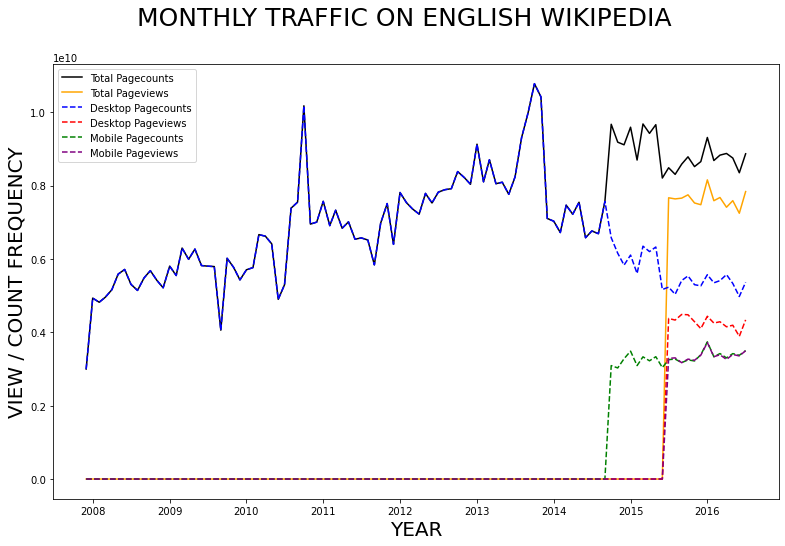

In [144]:
#Create figure and set size
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)

#Plot the data!

#all views
ax.plot(date, page_and_counts_df['pagecounts_all_views'], color = 'black')
ax.plot(date, page_and_counts_df['pageviews_all_views'], color = 'orange')

#desktop views
ax.plot(date, page_and_counts_df['pagecount_desktop_views'], color = 'blue', linestyle = '--')
ax.plot(date, page_and_counts_df['pageview_desktop_views'], color = 'red', linestyle = '--')

#mobile views
ax.plot(date, page_and_counts_df['pagecount_mobile_views'], color = 'green', linestyle = '--')
ax.plot(date, page_and_counts_df['pageview_mobile_views'], color = 'purple', linestyle = '--')


#Create axis labels, title, and legend

#legend
plt.legend(["Total Pagecounts", "Total Pageviews", "Desktop Pagecounts", "Desktop Pageviews", "Mobile Pagecounts", "Mobile Pageviews"])

#title
fig.suptitle('MONTHLY TRAFFIC ON ENGLISH WIKIPEDIA', fontsize=25)

#axis labels
ax.set_ylabel('VIEW / COUNT FREQUENCY', fontsize = 20)
ax.set_xlabel('YEAR', fontsize = 20)

#Display figure
plt.show()